<a href="https://colab.research.google.com/github/farheenfathimaa/NLP-with-Disaster-Tweets/blob/main/Natural_Language_Processing_with_Disaster_Tweets_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mounting drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
# Unzip the uploaded data into Google Drive
#!unzip "/content/drive/MyDrive/nlp-getting-started.zip" -d "/content/drive/MyDrive/nlp-tweets"

# Natural Language Processing with Disaster Tweets

This notebook looks into various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

We're going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

It is available on Kaggle. [Link](https://www.kaggle.com/competitions/nlp-getting-started/overview)



In [3]:
#!pip install tensorflow

The code below is the copy of [Link](https://www.kaggle.com/code/nabeelparuk/nlp-disaster-tweet-sentiment-analysis)

This is attempt of understanding the real time working on a NLP problem

## Importing modules

In [4]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization, Embedding
import tensorflow_hub as hub
#import tensorflow_text as text

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import random
import datetime
import matplotlib.pyplot as plt
import io
from IPython.display import FileLink

import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis
### Import data

In [5]:
train_df = pd.read_csv("/content/drive/MyDrive/nlp-tweets/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/nlp-tweets/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df_shuffled = train_df.sample(frac=1, random_state=1)
train_df_shuffled.head()

,id,keyword,location,text,target
3228,4632,emergency%20services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1
3706,5271,fear,NaN,The things we fear most in organizations--fluc...,0
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0
2887,4149,drown,NaN,@POTUS you until you drown by water entering t...,0
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\nThese wounds they will no...,1


In [7]:
train_df.isna().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [8]:
train_df["target"].value_counts()

,count
target,
0,4342
1,3271


In [9]:
# Visualising few samples
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target>0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
Forest fires &amp; dying salmon: time 2 act not deny. Climate Change Nightmares Are  Here http://t.co/RBZomWGjeE #bcpoli #canpoli #vanpoli

---

Target: 1 (real disaster)
Text:
I hope this tsunami clears b4 i have to walk outside to my car ????

---

Target: 0 (not real disaster)
Text:
Only one commodity has escaped the total collapse in prices http://t.co/4HngTKDQMv #business

---

Target: 0 (not real disaster)
Text:
@montetjwitter11 @Mets @audreyp77 @teena_797 @darryl_brooks @EliteSportsNY @LopezandtheLion no panic from #NatsNation but concern for sure

---

Target: 0 (not real disaster)
Text:
@BritishBakeOff This has opened up old baked alaskan shaped wounds. Too soon GBBO too soon... #neverforget

---



## Preprocessing
### Split into training and validation data

In [10]:
# Set target and predictors
X = train_df_shuffled["text"].to_numpy()
y = train_df_shuffled["target"].to_numpy()

# Split
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  random_state=42,
                                                  test_size=0.2)

###Text vectorization

In [11]:
# Find average number of tokens in tweets
round(sum([len(i.split()) for i in X_train])/len(X_train))

15

In [12]:
# Set custom parameters
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=max_length)
text_vectorizer.adapt(X_train)

In [13]:
# Test on random sentence
random_sentence = random.choice(X_train)
print(f"Text:\n{random_sentence}\n\nAfter vectorization:\n{text_vectorizer([random_sentence])}")

Text:
Fotoset: elanorofrohan: 10th December 2013 Green Carpet in Zurich for the Swiss Premiere of The Desolation... http://t.co/BQ3P7n7w06

After vectorization:
[[   1    1 5868 3637 1123  956 5538    4 5949   10    2 4141 4491    6
     2]]


Let's look at some common words

In [14]:
# Get common values
vocab_words = text_vectorizer.get_vocabulary()

# Get the least and the most common words
most_common = vocab_words[:5]
least_common = vocab_words[-5:]
print(f"Most common: {most_common}\nLeast_common: {least_common}")

Most common: ['', '[UNK]', 'the', 'a', 'in']
Least_common: ['mildmannered', 'milc5040h', 'mil', 'mikecroninwmur', 'mihirssharma']


## Embedding
We use embedding to make the vectorized text learnable

In [15]:
# Create embedding layer
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length,
                             name="embedding_1")

In [16]:
# Choose random sentence
random_sentence = random.choice(X_train)
print("Original sentence:", random_sentence)

# Embed sentence -> can't use straight text
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original sentence: Schools in Western Uganda still Burning down Buildings during Strikes....Strikes in Western Uganda always Lit literally..


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02420163, -0.04349962, -0.03863385, ..., -0.02034537,
         -0.04366361, -0.01914276],
        [-0.04077766,  0.01223524, -0.00932389, ..., -0.02481484,
          0.01261631, -0.02280289],
        [-0.04361731,  0.0403886 ,  0.00691257, ...,  0.03535077,
          0.044968  , -0.04802369],
        ...,
        [-0.04111264,  0.03568644, -0.0159073 , ..., -0.0468916 ,
          0.04822773, -0.03998127],
        [-0.00138788, -0.03900781, -0.04024399, ...,  0.0271428 ,
          0.02872436, -0.04306498],
        [ 0.02898305,  0.016501  , -0.00189836, ...,  0.01512687,
          0.03555821,  0.01803103]]], dtype=float32)>

## Model Construction
Define useful functions

*Metrics dictionary*

In [17]:
def metrics_dict(y_true, y_preds):
  """Gives the accuracy, precision, recall and f1 score"""
  acc = accuracy_score(y_true, y_preds)
  prec = precision_score(y_true, y_preds)
  recall = recall_score(y_true, y_preds)
  f1 = f1_score(y_true, y_preds, average="weighted")

  metrics = {"Accuracy":acc,
             "Precision":prec,
             "Recall":recall,
             "F1 Score":f1}
  return metrics

*TensorBoard Callback*

In [18]:
def create_tensorboard_callback(dir_name, exp_name):
  """
  Create a TensorBoard callback to store log files

  Store log files with filepath:
  "dir_name/exp_name/current_datetime"

  Args:
    dir_name: Target directory
    exp_name: Name of the experiment directory
  """
  log_dir = dir_name + "/" + exp_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

SAVE_DIR = "/content/drive/MyDrive/nlp-tweets/model_logs"

## Model 0 | Naive Bayes | Baseline Model
### Build model

In [19]:
# Create vectorizer
bayes_vectorizer = TfidfVectorizer()

# Build pipeline
model_0 = Pipeline([
    ("tfidf", bayes_vectorizer),
    ("clf", MultinomialNB())
])

# Fit the model
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

###Evaluate model

In [20]:
# Get predictions
model_0_preds = model_0.predict(X_val)

# Compute metrics
model_0_metrics = metrics_dict(y_val, model_0_preds)
model_0_metrics

{'Accuracy': 0.8089297439264609,
 'Precision': 0.8636363636363636,
 'Recall': 0.6363636363636364,
 'F1 Score': 0.8025095513670459}

## Model 1 | Feed-forward Neural Network
### Build Model

In [21]:
# Build model (using fuctional API)
inputs = layers.Input(shape=(1, ), dtype=tf.string)

# Turn text into numbers
x = text_vectorizer(inputs)
x = embedding(x)

# Hidden layers
x = layers.GlobalAveragePooling1D()(x)

# Output layers
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs,
                         outputs,
                         name="model_1_feedforward")

# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_1 = model_1.fit(x=X_train,
                        y=y_train,
                        validation_data=(X_val, y_val),
                        epochs=5,
                        callbacks=[create_tensorboard_callback(SAVE_DIR,model_1.name)])

Saving TensorBoard log files to: /content/drive/MyDrive/nlp-tweets/model_logs/model_1_feedforward/20240830-160749
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6210 - loss: 0.6594 - val_accuracy: 0.7807 - val_loss: 0.5322
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8129 - loss: 0.4820 - val_accuracy: 0.8037 - val_loss: 0.4592
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8651 - loss: 0.3595 - val_accuracy: 0.8056 - val_loss: 0.4484
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8913 - loss: 0.2938 - val_accuracy: 0.7991 - val_loss: 0.4554
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9112 - loss: 0.2398 - val_accuracy: 0.8056 - val_loss: 0.4668


In [22]:
model_1.summary()

Model: "model_1_feedforward"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

### Evaluate model

In [23]:
# Get predictions
model_1_pred_probs = model_1.predict(X_val)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

# Compute metrics
model_1_metrics = metrics_dict(y_val, model_1_preds)
model_1_metrics

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


{'Accuracy': 0.8056467498358503,
 'Precision': 0.8047882136279927,
 'Recall': 0.696969696969697,
 'F1 Score': 0.8030211586644785}

<Figure size 640x480 with 0 Axes>

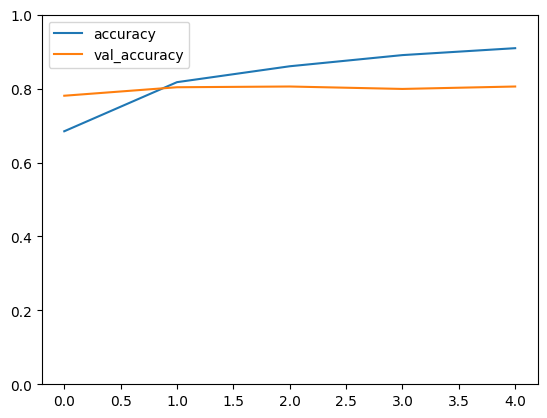

In [24]:
# Plot accuracy curves
history1_plot = pd.DataFrame(history_1.history)

plt.figure()
history1_plot.loc[ : ,["accuracy", "val_accuracy"]].plot()
plt.ylim(0,1);

### Visualise learned embedding
*Navigate to [TensorFlow Embedding Projector](https://projector.tensorflow.org/)*

In [25]:
# Get vocobulary
words_in_vocab = text_vectorizer.get_vocabulary()

# Get weight metrix of embeddign layer
embed_weights_model_1 = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights_model_1.shape)

(10000, 128)


### Download the files

In [26]:
# Create output writers
out_v = io.open("embedding_vectors_model1.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata_model1.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to files
for num, word in enumerate(words_in_vocab):
  if num==0:
    continue # skip padding token
  vec = embed_weights_model_1[num]
  out_m.write(word +"\n") # word to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

### Generate download links

In [27]:
FileLink("embedding_vectors.tsv")

/content/embedding_vectors.tsv

In [28]:
FileLink("embedding_metadata.tsv")

/content/embedding_metadata.tsv

##Model 2 | LSTM
###Build Model

In [29]:
# input
inputs = layers.Input(shape=(1,), dtype=tf.string)

# Turn text into numbers
x = text_vectorizer(inputs)
x = embedding(x)

# Hidden layers
x = layers.LSTM(128)(x)
x = layers.Dense(128)(x)

# Output layers
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs,
                        outputs,
                        name="model_2_lstm")

# compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history2 = model_2.fit(X_train,
                       y_train,
                       validation_data=[X_val, y_val],
                       epochs=10,
                       callbacks=[create_tensorboard_callback(SAVE_DIR, model_2.name)])

Saving TensorBoard log files to: /content/drive/MyDrive/nlp-tweets/model_logs/model_2_lstm/20240830-160811
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.8857 - loss: 0.2614 - val_accuracy: 0.7978 - val_loss: 0.5273
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9498 - loss: 0.1407 - val_accuracy: 0.7807 - val_loss: 0.8642
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9505 - loss: 0.1226 - val_accuracy: 0.7452 - val_loss: 0.7262
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9609 - loss: 0.0917 - val_accuracy: 0.7853 - val_loss: 0.8019
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9708 - loss: 0.0772 - val_accuracy: 0.7853 - val_loss: 0.8569
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9730 - loss: 0.0676 - val_accuracy: 0.7774 - val_loss: 1.4385
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9751 - loss: 0.0588 - val_accuracy: 0.7768 - val

In [30]:
model_2.summary()

Model: "model_2_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,284,677 (16.34 MB)

 Trainable params: 1,428,225 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,856,452 (10.90 MB)

###Evaluate the model

In [31]:
# Get predictions
model_2_pred_probs = model_2.predict(X_val)
model_2_preds = tf.squeeze(tf.round((model_2_pred_probs)))

# Compute metrics
model_2_metrics = metrics_dict(y_val, model_2_preds)
model_2_metrics

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


{'Accuracy': 0.7695338148391333,
 'Precision': 0.7247557003257329,
 'Recall': 0.7097288676236044,
 'F1 Score': 0.7691566330762356}

<Figure size 640x480 with 0 Axes>

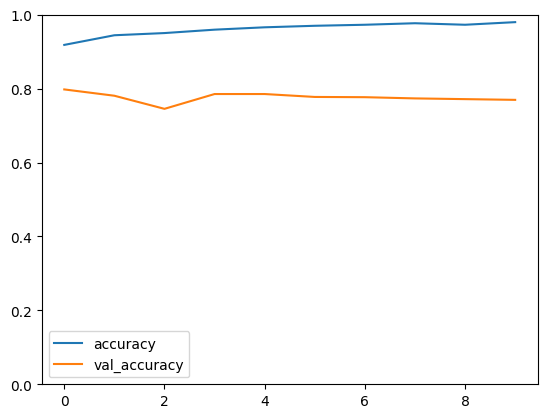

In [32]:
# Plot accuracy curves
history2_plot = pd.DataFrame(history2.history)

plt.figure()
history2_plot.loc[:,["accuracy", "val_accuracy"]].plot()
plt.ylim(0,1);

Still some overfitting
## Model 3 | GRU-Cell Powered RNN
The GRU-Cell Powered RNN (Recurrent Neural Network) is a type of RNN architecture that utilizes the Gated Recurrent Unit (GRU) cell as its building block.

**GRU Cell:**

* **Update Gate:** Controls how much information from the previous state should be passed to the current state.
* **Reset Gate:** Determines how much of the previous state should be forgotten when calculating the current state.
* **Output Gate:** Controls the amount of information from the current state that is passed to the next state.

**GRU-Cell Powered RNN:**

**Advantages:**
* Simpler than LSTM (Long Short-Term Memory) cells, making them computationally efficient.
Effective in capturing long-term dependencies in sequential data.
* Can be used for various tasks like language modeling, machine translation, and speech recognition.

**Disadvantages:**
* May not be as powerful as LSTM cells in certain scenarios, especially when dealing with complex sequential patterns.

> ***Overall, GRU-Cell Powered RNNs offer a good balance between performance and computational efficiency, making them a popular choice for many sequence-to-sequence tasks.***

###Build Model

In [33]:
# Input layer
inputs = layers.Input(shape=(1,), dtype=tf.string)

# Turn text into numbers
x = text_vectorizer(inputs)
x = embedding(x)

# Hidden layers
x = layers.GRU(128)(x)
x = layers.Dense(128)(x)

# Output layers
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs,
                         outputs,
                         name="model_3_GRU")

# compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history3 = model_3.fit(X_train,
                       y_train,
                       validation_data=[X_val, y_val],
                       epochs=10,
                       callbacks=[create_tensorboard_callback(SAVE_DIR, model_3.name)])

Saving TensorBoard log files to: /content/drive/MyDrive/nlp-tweets/model_logs/model_3_GRU/20240830-160957
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9189 - loss: 0.1963 - val_accuracy: 0.7544 - val_loss: 1.1574
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9757 - loss: 0.0582 - val_accuracy: 0.7590 - val_loss: 1.0525
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9784 - loss: 0.0449 - val_accuracy: 0.7597 - val_loss: 1.9525
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9740 - loss: 0.0700 - val_accuracy: 0.7459 - val_loss: 1.2610
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9785 - loss: 0.0407 - val_accuracy: 0.7577 - val_loss: 1.3770
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9828 - loss: 0.0334 - val_accuracy: 0.7538 - val_loss: 1.4464
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9808 - loss: 0.0349 - val_accuracy: 0.7538 - val_

In [34]:
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,187,141 (15.97 MB)

 Trainable params: 1,395,713 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,791,428 (10.65 MB)

###Evaluate model

In [35]:
# Get predictions
model_3_pred_probs = model_3.predict(X_val)
model_3_preds = tf.squeeze(tf.round((model_3_pred_probs)))

# Compute metrics
model_3_metrics = metrics_dict(y_val, model_3_preds)
model_3_metrics

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


{'Accuracy': 0.7406434668417596,
 'Precision': 0.6647727272727273,
 'Recall': 0.7464114832535885,
 'F1 Score': 0.7423232258016645}

<Figure size 640x480 with 0 Axes>

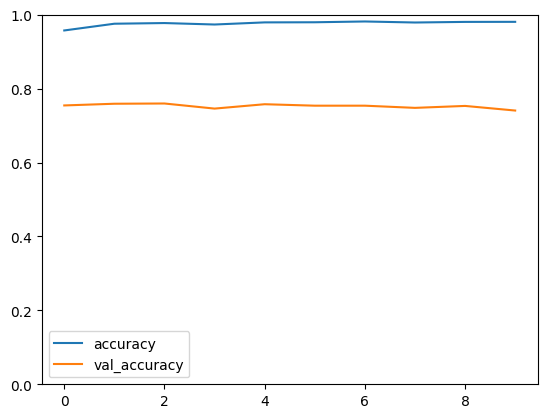

In [36]:
# plot accuracy curves
history3_plot = pd.DataFrame(history3.history)

plt.figure()
history3_plot.loc[:,["accuracy", "val_accuracy"]].plot()
plt.ylim(0,1);

##Model 4 | Bidirectional Neural Network
The LSTM clearly outperformed the GRU so we are going to use that in conjunction with the BiNN

### Build model

In [37]:
# Input layer
inputs = layers.Input(shape=(1,), dtype=tf.string)

# Turn string to numbers
x = text_vectorizer(inputs)
x = embedding(x)

# Hidden layer
x = layers.Bidirectional(layers.LSTM(128))(x)
x = layers.Dense(128)(x)

# Output layer
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs,
                         outputs,
                         name="Model_4_binn")

# compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history4 = model_4.fit(X_train,
                       y_train,
                       validation_data=[X_val, y_val],
                       epochs=10,
                       callbacks=[create_tensorboard_callback(SAVE_DIR, model_4.name)])

Saving TensorBoard log files to: /content/drive/MyDrive/nlp-tweets/model_logs/Model_4_binn/20240830-161139
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9585 - loss: 0.1377 - val_accuracy: 0.7341 - val_loss: 1.8662
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9792 - loss: 0.0382 - val_accuracy: 0.7334 - val_loss: 2.2890
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.9779 - loss: 0.0416 - val_accuracy: 0.7406 - val_loss: 2.2086
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.9808 - loss: 0.0399 - val_accuracy: 0.7676 - val_loss: 1.5713
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9822 - loss: 0.0316 - val_accuracy: 0.7544 - val_loss: 1.3748
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.9809 - loss: 0.0354 - val_accuracy: 0.7426 - val_loss: 1.2007
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9823 - loss: 0.0390 - val_accuracy: 0.7557 - 

In [38]:
model_4.summary()

Model: "Model_4_binn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,728,581 (18.04 MB)

 Trainable params: 1,576,193 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,152,388 (12.03 MB)

### Evaluate model

In [39]:
# Get predictions
model_4_pred_probs = model_4.predict(X_val)
model_4_preds = tf.squeeze(tf.round((model_4_pred_probs)))

# Compute the metrics
model_4_metrics = metrics_dict(y_val, model_4_preds)
model_4_metrics

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


{'Accuracy': 0.7518056467498359,
 'Precision': 0.7113752122241087,
 'Recall': 0.6682615629984051,
 'F1 Score': 0.7505044912435551}

<Figure size 640x480 with 0 Axes>

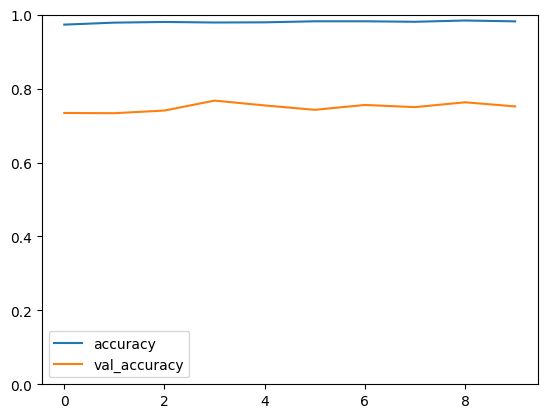

In [40]:
# plot the accuracy curve
history4_plot = pd.DataFrame(history4.history)

plt.figure()
history4_plot.loc[:, ["accuracy", "val_accuracy"]].plot()
plt.ylim(0,1);

## Model 5 | CNN
### Build Model

In [41]:
# input layer
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

# turn text to numbers
x = text_vectorizer(inputs)
x = embedding(x)

# hidden layers
x = layers.Conv1D(10, 3, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)

# output layers
outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs,
                         outputs,
                         name="model_5_cnn")

# compile
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit
history5 = model_5.fit(X_train,
                       y_train,
                       validation_data=[X_val, y_val],
                       epochs=10,
                       callbacks=[create_tensorboard_callback(SAVE_DIR, model_5.name)])

Saving TensorBoard log files to: /content/drive/MyDrive/nlp-tweets/model_logs/model_5_cnn/20240830-161501
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8111 - loss: 0.4620 - val_accuracy: 0.7925 - val_loss: 0.5215
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9534 - loss: 0.1486 - val_accuracy: 0.7873 - val_loss: 0.6661
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9687 - loss: 0.0938 - val_accuracy: 0.7722 - val_loss: 0.7866
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9783 - loss: 0.0694 - val_accuracy: 0.7597 - val_loss: 0.9000
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9760 - loss: 0.0625 - val_accuracy: 0.7525 - val_loss: 1.0083
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9844 - loss: 0.0467 - val_accuracy: 0.7518 - val_loss: 1.0850
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9808 - loss: 0.0469 - val_accuracy: 0.7511 - val_loss

In [42]:
model_5.summary()

Model: "model_5_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 13, 10)              │           3,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 10)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,851,585 (14.69 MB)

 Trainable params: 1,283,861 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,567,724 (9.80 MB)

###Evaluate model

In [43]:
# Get preds
model_5_pred_probs = model_5.predict(X_val)
model_5_preds = tf.squeeze(tf.round((model_5_pred_probs)))

# compute metrics
model_5_metrics = metrics_dict(y_val, model_5_preds)
model_5_metrics

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


{'Accuracy': 0.7491792514773473,
 'Precision': 0.6985413290113452,
 'Recall': 0.6874003189792663,
 'F1 Score': 0.7488670805202925}

<Figure size 640x480 with 0 Axes>

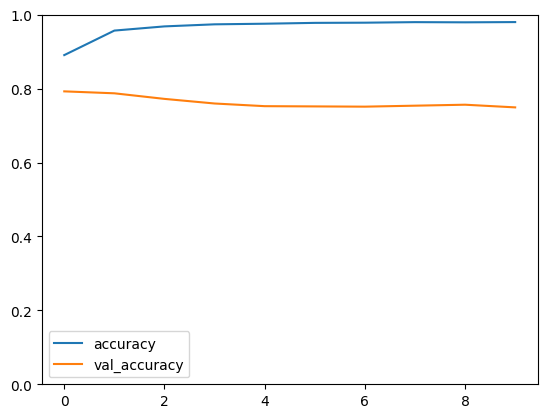

In [44]:
# Plot the accuracy curve
history5_plot = pd.DataFrame(history5.history)

plt.figure()
history5_plot.loc[:,["accuracy", "val_accuracy"]].plot()
plt.ylim(0,1);

##Model 6 | USE Feature Extractor
###Import USE and test embedding

In [45]:
use_embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")
use_embed_samples = use_embed(["When you use the universal encoder on a sentence, it turns it into numbers."])
use_embed_samples[0][:50]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([ 0.02248135, -0.08949932, -0.01029222, -0.00759968,  0.01276698,
       -0.0706287 , -0.06677136,  0.00215701,  0.04718043,  0.08474233,
       -0.03809093, -0.03091421,  0.0262356 ,  0.07135752,  0.06256957,
        0.00225534,  0.02755553, -0.05867716, -0.01160262,  0.05465818,
        0.01581769,  0.01556386,  0.04033247,  0.05218774, -0.07685868,
        0.06601251, -0.02816207, -0.00684569, -0.00036921,  0.06069897,
        0.02800913,  0.02646729, -0.01382347, -0.03609174, -0.10304508,
       -0.01896158,  0.01086119,  0.06148284,  0.01016747, -0.00619412,
       -0.00328086, -0.01699768,  0.04171554, -0.02337644,  0.03311285,
        0.01254029, -0.05408401, -0.06566295,  0.01324985, -0.01107214],
      dtype=float32)>

**Let's break down the code step by step:**

**1. Loading the Universal Sentence Encoder (USE) model:**

`use_embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")`

Here, we're using the hub library to load a pre-trained model from a URL. The URL points to the Universal Sentence Encoder (USE) model, which is a powerful language model developed by Google.

The hub library is a TensorFlow library that allows us to easily load and use pre-trained models. By loading the USE model, we can use its capabilities to encode sentences into numerical vectors.

**2. Encoding a sentence using the USE model:**

`use_embed_samples = use_embed(["When you use the universal encoder on a sentence, it turns it into numbers."])`

Here, we're using the loaded USE model to encode a sentence into a numerical vector. The input to the model is a list containing a single sentence: *"When you use the universal encoder on a sentence, it turns it into numbers."*

The use_embed function takes this sentence as input and returns a numerical vector representation of the sentence. This vector is often referred to as a "sentence embedding" or "sentence representation".

**3. Extracting the first 50 elements of the sentence embedding:**

`use_embed_samples[0][:50]`

Here, we're extracting the first 50 elements of the sentence embedding vector. The [0] indexing extracts the first element of the use_embed_samples list, which contains the sentence embedding vector. The [:50] slicing extracts the first 50 elements of this vector.

Why are we using this code?

We're using this code to demonstrate the Universal Sentence Encoder (USE) model's ability to encode sentences into numerical vectors. The USE model is a powerful tool for natural language processing (NLP) tasks, such as:

* Sentence similarity analysis
* Text classification
* Sentiment analysis
* Question answering
* Language translation

By encoding sentences into numerical vectors, we can perform various NLP tasks more efficiently and effectively. For example, we can use these vectors to compute similarities between sentences, classify text, or train machine learning models for downstream NLP tasks.

In this specific code, we're encoding a sentence and extracting the first 50 elements of the sentence embedding vector. This can be useful for visualizing the sentence embedding, computing similarities with other sentences, or using the vector as input to a downstream machine learning model.

###Build Model

In [54]:
import tensorflow_hub as hub
print(hub.__version__)

0.16.1


In [55]:
pip install --upgrade tensorflow-hub

In [64]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

# Build encoding layer
use_encoder_layer = hub.KerasLayer(
    "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name="USE"
)

# Custom layer to handle TensorFlow Hub KerasLayer
class UseLayer(tf.keras.layers.Layer):
    def __init__(self, encoder):
        super(UseLayer, self).__init__()
        self.encoder = encoder

    def call(self, inputs):
        return self.encoder(tf.convert_to_tensor(inputs))

# Build model using Functional API
inputs = tf.keras.Input(shape=(), dtype=tf.string)  # Adjusted input shape and dtype
x = UseLayer(use_encoder_layer)(inputs)  # Use the custom layer
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name="model_6_use")(x)

model_6 = tf.keras.Model(inputs, outputs)

# Compile model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit model
history6 = model_6.fit(X_train, y_train,
                       validation_data=(X_val, y_val),
                       epochs=10,
                       callbacks=[create_tensorboard_callback(SAVE_DIR, model_6.name)])

Saving TensorBoard log files to: /content/drive/MyDrive/nlp-tweets/model_logs/functional/20240830-163433
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7227 - loss: 0.5934 - val_accuracy: 0.8083 - val_loss: 0.4265
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8151 - loss: 0.4147 - val_accuracy: 0.8155 - val_loss: 0.4145
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8260 - loss: 0.4068 - val_accuracy: 0.8109 - val_loss: 0.4118
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8180 - loss: 0.4115 - val_accuracy: 0.8175 - val_loss: 0.4117
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8280 - loss: 0.3913 - val_accuracy: 0.8162 - val_loss: 0.4117
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8342 - loss: 0.3826 - val_accuracy: 0.8194 - val_loss: 0.4090
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8398 - loss: 0.3713 - val_accuracy: 0.8240 - val_loss:

In [65]:
model_6.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ use_layer (UseLayer)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ model_6_use (Dense)                  │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,693 (385.52 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,796 (257.02 KB)

###Evaluate model

In [66]:
# Get predictions
model_6_pred_probs = model_6.predict(X_val)
model_6_preds = tf.squeeze(tf.round((model_6_pred_probs)))

# compute metrics
model_6_metrics = metrics_dict(y_val, model_6_preds)
model_6_metrics

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


{'Accuracy': 0.8200919238345371,
 'Precision': 0.7936772046589018,
 'Recall': 0.7607655502392344,
 'F1 Score': 0.819473830902032}

<Figure size 640x480 with 0 Axes>

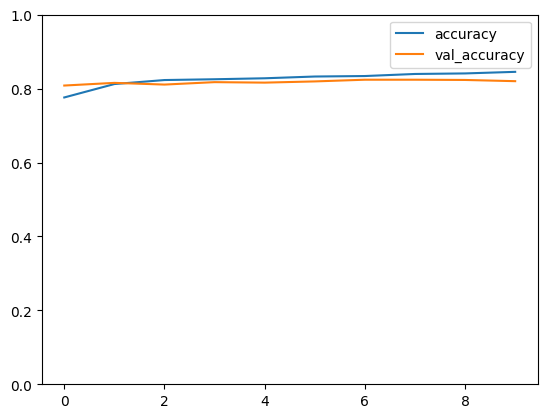

In [68]:
# Plot accuracy curves
history6_plot = pd.DataFrame(history6.history)

plt.figure()
history6_plot.loc[:,["accuracy", "val_accuracy"]].plot()
plt.ylim(0, 1);

## Model 7 | BERT
**BERT** - Bidirectional Encoder Representations from Transformers
###Preprocessing layer

In [74]:
# # URL of the preprocessing model on TensorFlow Hub
# bert_preproc_model = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

# # Load the preprocessing model directly from TensorFlow Hub
# bert_preproc_layer = hub.KerasLayer(bert_preproc_model, name="preprocessing")

In [75]:
# # Test
# text_test = ['this is such an amazing movie!']
# text_preprocessed = bert_preproc_model(text_test)

# print(f'Keys       : {list(text_preprocessed.keys())}')
# print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
# print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
# print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

### Build Model

In [77]:
# # Build encoding layer
# bert_encoder_layer = hub.KerasLayer("/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2",
#                                   input_shape=[],
#                                   dtype=tf.string,
#                                   trainable=False,
#                                   name="BERT")

In [78]:
# # Build model
# # - Input layer
# inputs = tf.keras.Input(shape=(), dtype=tf.string)

# # - Preprocessing
# x = bert_preproc_layer(inputs)

# # - Encoder
# x = bert_encoder_layer(x)
# x = x['pooled_output']
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dense(128, activation='relu')(x)

# # - Output layer
# outputs = layers.Dense(1, activation='sigmoid')(x)
# model_7 = tf.keras.Model(inputs, outputs, name='model_7_bert')

# # Compile model
# model_7.compile(loss='binary_crossentropy',
#                optimizer=tf.keras.optimizers.Adam(),
#                metrics=['accuracy'])

# # Fit model
# history7 = model_7.fit(train_sentences, train_labels,
#                       validation_data=[val_sentences, val_labels],
#                       epochs=10, callbacks=[create_tensorboard_callback(SAVE_DIR, model_7.name)])

###Evaluate Model

In [79]:
# # Get predictions
# model_7_pred_probs = model_7.predict(val_sentences)
# model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))

# # Get metrics
# model_7_metrics = metrics_dict(val_labels, model_7_preds)
# model_7_metrics

In [80]:
# # Plot accuracy curves
# history7_plot = pd.DataFrame(history7.history)

# plt.figure()
# history7_plot.loc[ : ,['accuracy', 'val_accuracy']].plot()
# plt.ylim(0, 1)

##Model 8 | Pretrained NNLM
###Import NNLM
###Import NNLM and test embedding

In [82]:
# nnlm_embed = hub.load("/kaggle/input/nnlm/tensorflow2/en-dim128/1")

# nnlm_embed_samples = nnlm_embed(["When you use the neural network language model on a sentence, it turns it into numbers."])
# nnlm_embed_samples[0][:50]

###Build Model

In [83]:
# # Create encoder layer
# nnlm_encoder_layer = hub.KerasLayer("/kaggle/input/nnlm/tensorflow2/en-dim128/1",
#                                    dtype=tf.string,
#                                    input_shape=[],
#                                    name="NNLM")

In [84]:
# # Build model
# model_8 = tf.keras.Sequential([
#     # Encoder
#     nnlm_encoder_layer,
#     layers.Dense(64, activation='relu'),

#     # Decoder
#     layers.Dense(1, activation='sigmoid')
# ], name='model_8_nnlm')

# # Compile model
# model_8.compile(loss='binary_crossentropy',
#                optimizer=tf.keras.optimizers.Adam(),
#                metrics=['accuracy'])

# # Fit model
# history8 = model_8.fit(train_sentences, train_labels,
#            validation_data=[val_sentences, val_labels],
#            epochs=10, callbacks=[create_tensorboard_callback(SAVE_DIR, model_8.name)])

###Evaluate Model

In [88]:
# # Get predictions
# model_8_pred_probs = model_8.predict(val_sentences)
# model_8_preds = tf.squeeze(tf.round(model_8_pred_probs))

# # Get metrics
# model_8_metrics = metrics_dict(val_labels, model_8_preds)
# model_8_metrics

In [87]:
# # Plot accuracy curves
# history8_plot = pd.DataFrame(history8.history)

# plt.figure()
# history8_plot.loc[ : , ['accuracy', 'val_accuracy']].plot()
# plt.ylim(0, 1)

All the models are getting similar results. We need to look at individual cases of what is happening.

##Visualising specific predictions

In [89]:
incorrect = np.where(model_6_preds != y_val)
incorrect = incorrect[0]
print(f"{len(incorrect)} incorrectly classified tweets")

274 incorrectly classified tweets


Lets visualise a few

In [91]:
for i in range(5):
    rand_num = random.randint(0, int(len(incorrect)-1))
    print(f"Sentence: {X_val[incorrect[rand_num]]}\nTrue Label: {y_val[incorrect[rand_num]]}\nPredicted Label: {1 if y_val[incorrect[rand_num]] == 0 else 0}")
    print("--------------------------------------------------------------------")

Sentence: Ah yes the gays are totally destroying America. I can see buildings burning and meteors crashing into schools wow
True Label: 0
Predicted Label: 1
--------------------------------------------------------------------
Sentence: @USArmy has entered into the #JAGM project to replace #TOW and Hellfire missiles. Check it out here: http://t.co/2mnQC73hFk
True Label: 0
Predicted Label: 1
--------------------------------------------------------------------
Sentence: Governor weighs parole for California school bus hijacker http://t.co/7NPBfRzEJL http://t.co/Y0kByy8nce
True Label: 0
Predicted Label: 1
--------------------------------------------------------------------
Sentence: If this ATL to San Fran flight goes down in a  desolate square state it's been real Twitter.
True Label: 0
Predicted Label: 1
--------------------------------------------------------------------
Sentence: New post from @darkreading http://t.co/8eIJDXApnp New SMB Relay Attack Steals User Credentials Over Interne

We can clearly see how the tweets are either neutral or over exaggerated and can infer how the model is getting confused. In some cases, the model seems to have predicted better than the assigned label.

##Generate Submission File

In [92]:
X_test = test_df["text"].to_numpy()

In [94]:
# Read in sample submission
# Read in sample submission
sample_submission = pd.read_csv("/content/drive/MyDrive/nlp-tweets/sample_submission.csv")

model_final_pred_probs = model_6.predict(X_test)
model_final_preds = tf.squeeze(tf.round((model_final_pred_probs)))

sample_submission["target"] = model_final_preds
sample_submission["target"] = sample_submission["target"].astype('int64')
sample_submission.to_csv("submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
